In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [2]:
# reading the dataset

df = pd.read_csv("reviews.csv")

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

In [5]:
# checking for null values in a dataset

df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [6]:
# dropping null values

df = df.dropna()

In [7]:
df.shape

(568411, 10)

In [8]:
df["Score"].value_counts()

5    363111
4     80655
1     52264
3     42638
2     29743
Name: Score, dtype: int64

In [9]:
# dropping all rows with Score equal to 3

df = df[df.Score != 3]
df.shape

(525773, 10)

In [10]:
# adding is positive feature to the dataset

is_positive = []

for i in df["Score"].values:
    if(i == 1 or i ==2):
        is_positive.append(0)
    else:
        is_positive.append(1)

df["is positive"] = is_positive        

In [11]:
# dropping Score feature

df = df.drop(columns = ["Score"])

In [12]:
# Checkinng for duplicate rows

df_duplicated = df[df.duplicated(['UserId','ProfileName','Time','Summary','Text'], keep ='first')]
df_duplicated.shape

(160452, 10)

In [13]:
# dropping the duplicate rows

df_dedup = df.drop_duplicates(subset = ['UserId','ProfileName','Time','Summary','Text'], keep ='first')
df_dedup.shape

(365321, 10)

In [14]:
# checking if HelpfulnessNumerator is greater than HelpfulnessDenominator in any of the rows

df_dedup[df_dedup.HelpfulnessNumerator > df_dedup.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,is positive
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,1
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,1


In [15]:
# dropping the rows where HelpfulnessNumerator is greater than HelpfulnessDenominator

df_dedup = df_dedup.drop(df_dedup.index[[44736, 64421]])

# Text preprocessing

In [16]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [17]:
# functions for stripping html tags and punctuations from the text

def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

def cleanpunc(data):
    cleandata = re.sub(r'[^A-Za-z]+',r' ',data)
    cleandata = re.sub(r'[?|!|\'|"|#]',r'',cleandata)
    cleandata = re.sub(r'[.|,|)|(|/|\|<|>|:|;|{|}|*|&|^|%|$|!]',r'',cleandata)
    return cleandata

In [18]:
# Stopword removal
# removing html tags
# removing punctuation
# checking if the words are alphanumeric
# giving more weight to summary
# stemming
# removing the wprds of length less than or equal to 2

reviews = []

for summary, text in tqdm(zip(df_dedup["Summary"].values, df_dedup["Text"].values)):
    
    text = striphtml(text)

    summary = striphtml(summary)

    text = cleanpunc(text)

    summary = cleanpunc(summary)

    review = str(summary)+" "+str(summary)+" "+str(summary)+" "+str(text)

    review = cleanpunc(review)

    words = word_tokenize(str(review.lower())) 

    review = ' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)>2) and (j.isalpha()))      

    reviews.append(review)

365319it [14:09, 430.03it/s]


In [19]:
df_dedup["reviews"] = reviews

In [20]:
# Dropping useless features

df_dedup = df_dedup.drop(columns = ["Id","ProductId","UserId","ProfileName","Summary","Text"])

In [21]:
# adding helpfulnessRatio to the dataset

SAFE_DIV = 0.00001

hr = []

for i in range(365319):
    hr.append(df_dedup["HelpfulnessNumerator"].values[i] / (df_dedup["HelpfulnessDenominator"].values[i] + SAFE_DIV))
    
df_dedup["HelpfulnessRatio"] = hr    

In [22]:
df_dedup.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Time,is positive,reviews,HelpfulnessRatio
0,1,1,1303862400,1,good qualiti dog food good qualiti dog food go...,0.999990
1,0,0,1346976000,0,advertis advertis advertis product arriv label...,0.000000
2,1,1,1219017600,1,delight say delight say delight say confect ar...,0.999990
3,3,3,1307923200,0,cough medicin cough medicin cough medicin look...,0.999997
4,0,0,1350777600,1,great taffi great taffi great taffi great taff...,0.000000


(-20, 100)

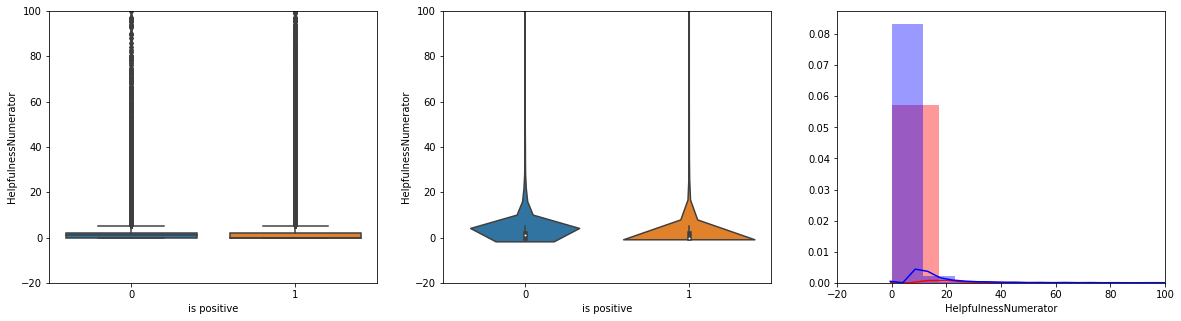

In [23]:
# Analysing HelpfulnessNumerator

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is positive", y = "HelpfulnessNumerator", data = df_dedup)
plt.ylim(-20,100)

plt.subplot(1,3,2)
sns.violinplot(x = "is positive", y = "HelpfulnessNumerator", data = df_dedup)
plt.ylim(-20,100)

plt.subplot(1,3,3)
sns.distplot(df_dedup[df_dedup['is positive'] == 1.0]['HelpfulnessNumerator'][0:] , label = "1", color = 'red')
sns.distplot(df_dedup[df_dedup['is positive'] == 0.0]['HelpfulnessNumerator'][0:] , label = "0" , color = 'blue' )
plt.xlim(-20,100)

(-20, 100)

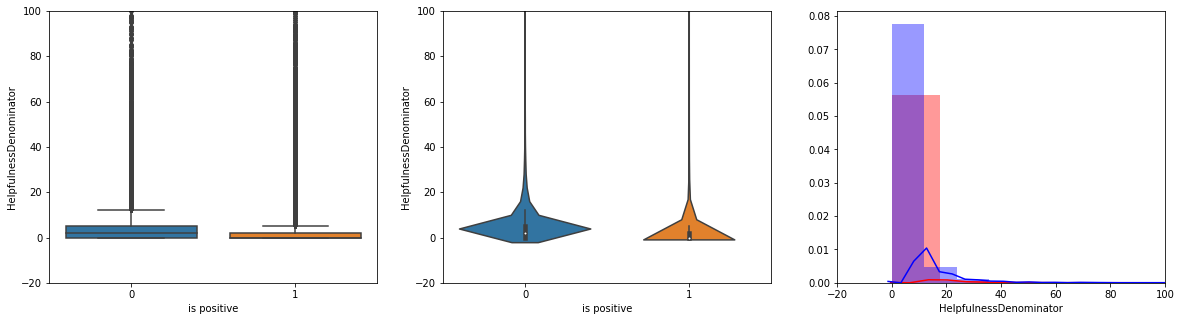

In [24]:
# Analysing HelpfulnessDenominator

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is positive", y = "HelpfulnessDenominator", data = df_dedup)
plt.ylim(-20,100)

plt.subplot(1,3,2)
sns.violinplot(x = "is positive", y = "HelpfulnessDenominator", data = df_dedup)
plt.ylim(-20,100)

plt.subplot(1,3,3)
sns.distplot(df_dedup[df_dedup['is positive'] == 1.0]['HelpfulnessDenominator'][0:] , label = "1", color = 'red')
sns.distplot(df_dedup[df_dedup['is positive'] == 0.0]['HelpfulnessDenominator'][0:] , label = "0" , color = 'blue' )
plt.xlim(-20,100)

(0, 4)

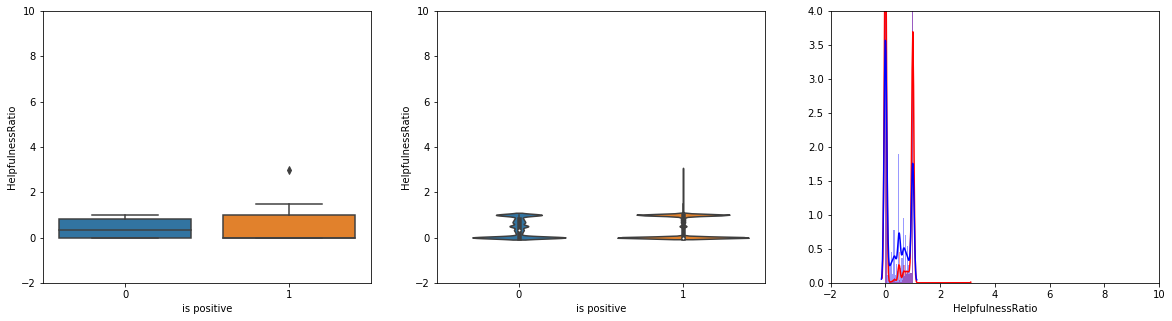

In [25]:
# Analysing HelpfulnessRatio

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is positive", y = "HelpfulnessRatio", data = df_dedup)
plt.ylim(-2,10)

plt.subplot(1,3,2)
sns.violinplot(x = "is positive", y = "HelpfulnessRatio", data = df_dedup)
plt.ylim(-2,10)

plt.subplot(1,3,3)
sns.distplot(df_dedup[df_dedup['is positive'] == 1.0]['HelpfulnessRatio'][0:] , label = "1", color = 'red')
sns.distplot(df_dedup[df_dedup['is positive'] == 0.0]['HelpfulnessRatio'][0:] , label = "0" , color = 'blue' )
plt.xlim(-2,10)
plt.ylim(-0,4)

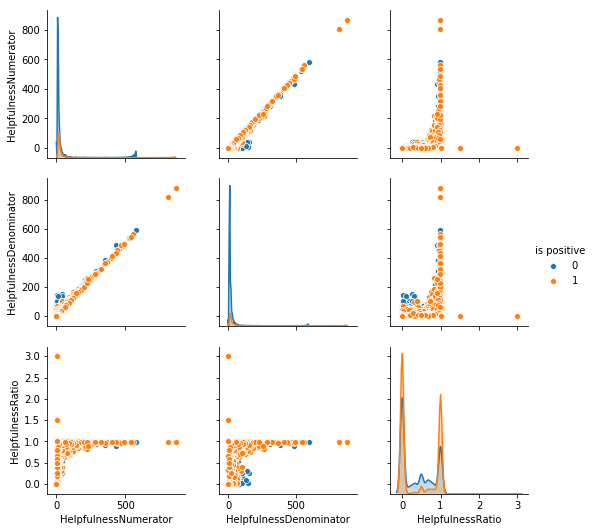

In [26]:
sns.pairplot(df_dedup, vars = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'HelpfulnessRatio'], hue ='is positive')

In [27]:
df_dedup.to_csv("preprocessed1.csv", index = False)